In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
from scipy.optimize import curve_fit


data = pd.read_csv ("Allsupernovae.csv") #reading in supernovae data and creating data frame 'data'

cosmo = FlatLambdaCDM(H0=70, Om0=0.287) #H0 value from Betoule et al. 2014, omega_m best fit value from JLA sample, 
                                        #cosmological model assuming flat Universe


#Calculating distances 
data['d_L'] = cosmo.luminosity_distance(data.zcmb) #changing cmb redshift to distance in Mpc

#Distance modulus eq 
#mu = 5log(d_L/10pc) or bmag-absmag = mu = 5 log10(D_L) + 25 if D_L is in Mpc
data['mu'] = 5*(np.log10(data.d_L)) + 25

#redshift values for cosmological fit
#can't use float in for loop so have to implement it before loop 
def frange(start, stop, step):
        i = start
        while i < stop:
            yield i
            i += step

redshift=[]
y=[]

for i in frange(0.01, 1, 0.01):
    dist = cosmo.luminosity_distance(i)
    dist *= pow(10,6) 
    dist = dist*(1./u.Mpc)
    mu_1 = 5*np.log10(dist/10)
    redshift.append((i))
    y.append((mu_1.value))
    
#mass step function array (correction only)
data['MBstep'] = data.loc[data['LogMst'] >= 10,['mydeltaM']] #records mydeltaM in array if LogMst >=10
data['MBstep'].fillna(0, inplace=True) #otherwise records 0
mass_corr = np.array(data.MBstep) #array of mass step corrections (i.e. either -0.049 or 0)

#step function correction for sSFR
data['MBstep2'] = data.loc[data['logsSFR'] <= -10.5,['deltaM_sSFR']]
data['MBstep2'].fillna(0, inplace=True)
sSFR_corr = np.array(data.MBstep2)

#errors
data['err_dm'] = data.error_mb + (0.01 + (0.117*data.error_X1)*(0.006*data.X1) + (2.450*data.error_c)*(0.070*data.c))
data['err_dm_mass'] = data.error_mb + (0.01 + (0.124*data.error_X1)*(0.006*data.X1) + (2.476*data.error_c)*(0.070*data.c))
data['err_dm_sSFR'] = data.error_mb + (0.01 + (0.120*data.error_X1)*(0.006*data.X1) + (2.460*data.error_c)*(0.070*data.c))
data['err_dm_both'] = data.error_mb + (0.01 + (0.127*data.error_X1)*(0.006*data.X1) + (2.486*data.error_c)*(0.070*data.c))

#Distance modulus eq (no corrections)
data['distance_modulus'] = data.mb - (-19.10 - 0.117*data.X1 + 2.450*data.c)
                                                      
#Distance modulus with mass step correction
data['dist_mod_mass'] = data.mb - ((-19.07 + mass_corr) - 0.124*data.X1 + 2.476*data.c) 
                                                                
#Distance modulus with sSFR step correction
data['dist_mod_sSFR'] = data.mb - ((-19.09 + sSFR_corr)- 0.120*data.X1 + 2.460*data.c) 

#Distance modulus with mass & sSFR step correction
data['dist_mod_both'] = data.mb - ((-19.06 + mass_corr + sSFR_corr) - 0.127*data.X1 + 2.486*data.c) 


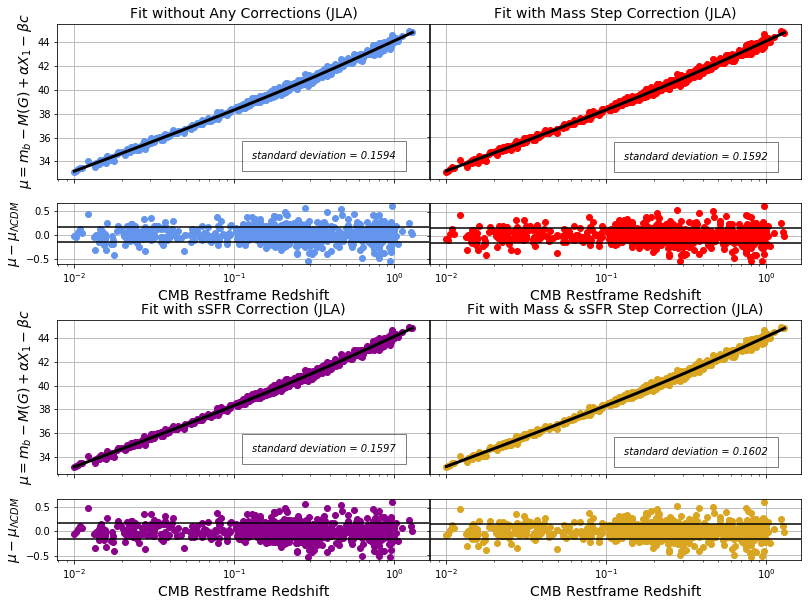

In [32]:
fig = plt.figure(figsize=(20,10)) 

#main plots

#plot without mass or sSFR correction
plt.subplot2grid((70,60),(0,0), rowspan=20, colspan=20)
plt.plot(data.zcmb, data.distance_modulus, 'o', color='cornflowerblue')   #supernovae
plt.plot(np.sort(data.zcmb), np.sort(data.mu), linewidth=3, color='k')  #cosmology
plt.tick_params(labelbottom='off') #takes ticks off bottom axis for axis sharing
plt.subplots_adjust(wspace=0.01)

plt.xscale('log')
plt.title('Fit without Any Corrections (JLA)', fontsize=14)
plt.ylabel(r'$\mu = m_{b} - M(G) + \alpha X_{1} - \beta c$', fontsize=14)
plt.grid(True)


#plot with mass step correction
plt.subplot2grid((70,60),(0,20), rowspan=20, colspan=20)
plt.plot(data.zcmb, data.dist_mod_mass, 'o', color='r')   #supernovae
plt.plot(np.sort(data.zcmb), np.sort(data.mu), linewidth=3, color='k')  #cosmology
plt.tick_params(labelbottom='off')
plt.tick_params(labelleft='off') #takes ticks off left axis for axis sharing

plt.title('Fit with Mass Step Correction (JLA)', fontsize=14)
plt.xscale('log')
plt.grid(True)


#plot with sSFR step correction
plt.subplot2grid((70,60),(38,0), rowspan=20, colspan=20)
plt.plot(data.zcmb, data.dist_mod_sSFR, 'o', color='darkmagenta')   #supernovae
plt.plot(np.sort(data.zcmb), np.sort(data.mu), linewidth=3, color='k')  #cosmology
plt.tick_params(labelbottom='off')

plt.xscale('log')
plt.title('Fit with sSFR Correction (JLA)', fontsize=14)
plt.ylabel(r'$\mu = m_{b} - M(G) + \alpha X_{1} - \beta c$', fontsize=14)
plt.grid(True)

#plot with mass & sSFR step correction
plt.subplot2grid((70,60),(38, 20), rowspan=20, colspan=20)
plt.plot(data.zcmb, data.dist_mod_both, 'o', color='goldenrod')   #supernovae
plt.plot(np.sort(data.zcmb), np.sort(data.mu), linewidth=3, color='k')  #cosmology
plt.tick_params(labelleft='off')
plt.tick_params(labelbottom='off')

plt.title('Fit with Mass & sSFR Step Correction (JLA)', fontsize=14)
plt.xscale('log')
plt.grid(True)



#residuals for under plots
data['residuals_nostep'] = data.distance_modulus - data.mu
data['residuals_massstep'] = data.dist_mod_mass - data.mu #inc. mass step only
data['residuals_sSFRstep'] = data.dist_mod_sSFR - data.mu #inc. sSFR step only
data['residuals_both'] = data.dist_mod_both - data.mu #inc. both step corrections

#Standard Deviation
stat1 = np.std(data.residuals_nostep)
stat2 = np.std(data.residuals_massstep)
stat3 = np.std(data.residuals_sSFRstep)
stat4 = np.std(data.residuals_both)


#Mean
mean1 = np.mean(data.residuals_nostep)
mean2 = np.mean(data.residuals_massstep)
mean3 = np.mean(data.residuals_sSFRstep)
mean4 = np.mean(data.residuals_both)

#no corrections
plt.subplot2grid((70,60), (23,0), rowspan=8, colspan=20)
plt.plot(data.zcmb, data.residuals_nostep, 'o', color='cornflowerblue')

#plt.title('Residuals', fontsize=14)
plt.xscale('log')
plt.xlabel('CMB Restframe Redshift', fontsize=14)
plt.ylabel(r'$\mu - \mu_{\Lambda CDM}$', fontsize=14)
plt.grid(True)
plt.axhline(y=mean1+stat1, color='k')
plt.axhline(y=(mean1-stat1), color='k')
plt.text(0.13, 1.6, 'standard deviation = 0.1594', style='italic', bbox={'facecolor':'white', 'alpha':0.5, 'pad':10})


#mass step corrections
plt.subplot2grid((70,60), (23,20), rowspan=8, colspan=20)
plt.plot(data.zcmb, data.residuals_massstep, 'ro')

plt.xscale('log')
plt.xlabel('CMB Restframe Redshift', fontsize=14)
plt.tick_params(labelleft='off')
plt.grid(True)
plt.axhline(y=mean2+stat2, color='k')
plt.axhline(y=(mean2-stat2), color='k')
plt.text(0.13, 1.6, 'standard deviation = 0.1592', style='italic', bbox={'facecolor':'white', 'alpha':0.5, 'pad':10})


#sSFR corrections
plt.subplot2grid((70,60), (61,0), rowspan=8, colspan=20)
plt.plot(data.zcmb, data.residuals_sSFRstep, 'o', color='darkmagenta')

plt.xscale('log')
plt.xlabel('CMB Restframe Redshift', fontsize=14)
plt.ylabel(r'$\mu - \mu_{\Lambda CDM}$', fontsize=14)
plt.grid(True)
plt.axhline(y=mean3+stat3, color='k')
plt.axhline(y=(mean3-stat3), color='k')
plt.text(0.13, 1.6, 'standard deviation = 0.1597', style='italic', bbox={'facecolor':'white', 'alpha':0.5, 'pad':10})


#both step corrections
plt.subplot2grid((70,60), (61,20), rowspan=8, colspan=20)
plt.plot(data.zcmb, data.residuals_both, 'o', color='goldenrod')

#plt.title('Residuals', fontsize=14)
plt.xscale('log')
plt.xlabel('CMB Restframe Redshift', fontsize=14)
plt.tick_params(labelleft='off')
plt.grid(True)
plt.axhline(y=mean4+stat4, color='k')
plt.axhline(y=(mean4-stat4), color='k')
plt.text(0.13, 1.6, 'standard deviation = 0.1602', style='italic', bbox={'facecolor':'white', 'alpha':0.5, 'pad':10})


plt.show()
#fig.savefig('Comparison of Corrections (JLA).pdf')
plt.close(fig)

In [33]:
print(stat1, stat2, stat3, stat4)

0.1594109263958562 0.15922333984441703 0.1597457126022802 0.16017904573282482
